# Gamma ray spectrometry: spectrometer calibration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'
from scipy.optimize import curve_fit
from scipy.odr import unilinear, RealData, ODR
from scipy.interpolate import interp1d

In [2]:
peaks = pd.read_csv('final_peaks.csv')
peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy
0,Am241,17.055242,1.0,10.949870,1.0,26.3450,0.0010
1,Am241,48.949766,1.0,14.093629,1.0,59.5370,0.0010
2,Ba133,17.873519,1.0,11.895849,1.0,30.8507,0.0005
3,Ba133,67.937757,1.0,18.821271,2.0,80.9980,0.0080
4,Ba133,142.192815,2.0,39.449379,9.0,160.6050,0.0150
5,Ba133,275.049389,4.0,35.739316,18.0,302.8510,0.0150
6,Ba133,330.952029,1.0,43.324427,2.0,356.0050,0.0170
7,Co60,65.064552,1.0,25.459021,2.0,74.9690,0.0050
8,Co60,1081.715964,4.0,83.887352,15.0,1173.2080,0.0250
9,Co60,1226.627945,2.0,82.002000,16.0,1332.4910,0.0410


In [3]:
used_energy = np.array([1408, 1275, 779, 662, 511, 344, 245, 122, 59.5])
used_idx = np.any(np.abs(np.atleast_2d(peaks.energy) - np.atleast_2d(used_energy).T) < 1, axis=0)
used_peaks = peaks[used_idx]
unused_peaks = peaks[~used_idx]
used_peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy
1,Am241,48.949766,1.0,14.093629,1.0,59.537,0.001
12,Cs137,614.889306,1.0,61.092293,1.0,661.638,0.019
15,Eu152,107.910635,1.0,21.346148,1.0,121.783,0.009
16,Eu152,223.302063,1.0,35.958036,6.0,244.697,0.012
17,Eu152,319.267093,1.0,44.990162,6.0,344.274,0.012
18,Eu152,718.437316,3.0,75.522621,18.0,778.872,0.015
21,Eu152,1298.039945,1.0,91.915990,10.0,1408.024,0.030
23,Na22,468.748447,1.0,54.166027,1.0,511.006,0.010
24,Na22,1171.435123,4.0,86.462154,1.0,1274.511,0.028


In [5]:
def linear(x, slope, intercept):
    return slope*x + intercept

data = RealData(x=used_peaks.mean_peaks, y=used_peaks.energy,
                sx=used_peaks.peak_deltas, sy=used_peaks.delta_energy)
output = ODR(data, unilinear).run()
output.pprint()
params, delta_params = output.beta, output.sd_beta

fit = linear(used_peaks.mean_peaks, *params)
ss_res = np.sum((used_peaks.energy - fit)**2)
ss_tot = np.sum((used_peaks.energy - used_peaks.energy.mean())**2)
r_squared = 1 - ss_res/ss_tot
r_squared

Beta: [1.08022404 3.28321698]
Beta Std Error: [0.00308073 1.85136696]
Beta Covariance: [[ 1.02996725e-06 -4.64260010e-04]
 [-4.64260010e-04  3.71963280e-01]]
Residual Variance: 9.214779499268248
Inverse Condition #: 0.00110036391463707
Reason(s) for Halting:
  Sum of squares convergence


0.9999424895068586

In [37]:
params_out = pd.DataFrame({
    'beta': output.beta, 'delta_beta': output.sd_beta
})
params_out.to_csv('calibration_parameters.csv', index=False)
params_out

,beta,delta_beta
0,1.080224,0.003081
1,3.283217,1.851367


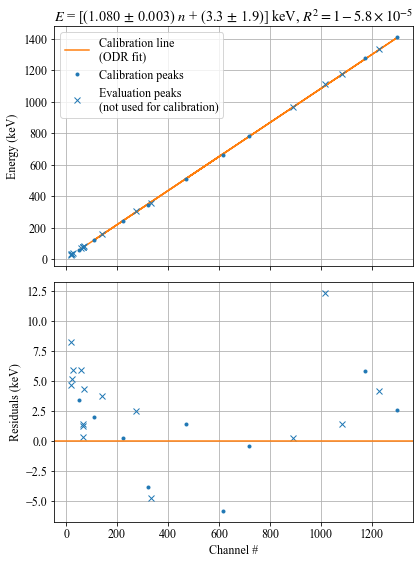

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))

ax1.plot(used_peaks.mean_peaks, fit, label='Calibration line\n(ODR fit)',
         color='tab:orange')
ax1.plot(used_peaks.mean_peaks, used_peaks.energy, '.', linestyle='',
        label='Calibration peaks', color='tab:blue')
ax1.plot(unused_peaks.mean_peaks, unused_peaks.energy, 'x', linestyle='',
        color='tab:blue', label='Evaluation peaks\n(not used for calibration)')
ax1.grid()
ax1.legend()
title = (
    '$E$ = [({:.3f} $\\pm$ {:.3f}) $n$ '
    '+ ({:.1f} $\\pm$ {:.1f})] keV, $R^2 = 1 - {:.1f} \\times 10^{{-5}}$'
).format(params[0], delta_params[0],
         params[1], delta_params[1], (1 - r_squared)*1e5)
ax1.set(ylabel='Energy (keV)', title=title)
ax1.set_xticklabels([])

ax2.plot(used_peaks.mean_peaks, used_peaks.energy - fit, '.', linestyle='')
ax2.plot(unused_peaks.mean_peaks,
        unused_peaks.energy - linear(unused_peaks.mean_peaks, *params),
        'x', color='tab:blue', linestyle='')
ax2.axhline(0, color='tab:orange')
ax2.grid()
ax2.set(xlabel='Channel #', ylabel='Residuals (keV)')

fig.tight_layout()
fig.savefig('figures/calibration.pdf', bbox_inches='tight')

In [16]:
calibration_params = params
def channel2energy(channel):
    return linear(channel, *calibration_params)

## Energy determination

In [30]:
delta_prediction = (
    unused_peaks.energy*delta_params[0]
    + unused_peaks.delta_energy*params[0]
    + delta_params[1]
)

unused_peaks = unused_peaks.assign(
    predicted_energy=linear(unused_peaks.mean_peaks, *params))
unused_peaks = unused_peaks.assign(delta_prediction=delta_prediction)
unused_peaks = unused_peaks.assign(
    prediction_error=(unused_peaks.predicted_energy - unused_peaks.energy))

used_peaks = used_peaks.assign(
    predicted_energy=np.full(len(used_peaks), np.nan),
    delta_prediction=np.full(len(used_peaks), np.nan),
    prediction_error=np.full(len(used_peaks), np.nan),
)

peaks = pd.concat([unused_peaks, used_peaks])
peaks = peaks[['isotope', 'energy', 'delta_energy',
               'predicted_energy', 'delta_prediction',]]
peaks = peaks.assign(
    error_sigma=((peaks.predicted_energy - peaks.energy)/peaks.delta_prediction)
)
peaks.isotope = [{
    'Am241': '$^{241}$Am', 'Ba133': '$^{133}$Ba', 'Co60': '$^{60}$Co',
    'Cs137': '$^{137}$Cs', 'Eu152': '$^{152}$Eu', 'Na22': '$^{22}$Na'
}[isotope] for isotope in peaks.isotope]
peaks = peaks.sort_values(['isotope', 'energy']).reset_index(drop=True)
peaks.to_csv('figures/peak_table.csv', index=False)
peaks

,isotope,energy,delta_energy,predicted_energy,delta_prediction,error_sigma
0,$^{133}$Ba,30.8507,0.0005,22.590622,1.946950,-4.242574
1,$^{133}$Ba,80.9980,0.0080,76.671215,2.109542,-2.051054
2,$^{133}$Ba,160.6050,0.0150,156.883314,2.362352,-1.575416
3,$^{133}$Ba,302.8510,0.0150,300.398179,2.800574,-0.875828
4,$^{133}$Ba,356.0050,0.0170,360.785555,2.966487,1.611520
5,$^{137}$Cs,32.0611,0.0005,26.901289,1.950679,-2.645136
6,$^{137}$Cs,74.9690,0.0050,73.783507,2.087728,-0.567839
7,$^{137}$Cs,661.6380,0.0190,NaN,NaN,NaN
8,$^{152}$Eu,39.9062,0.0005,34.014055,1.974847,-2.983595
9,$^{152}$Eu,74.9690,0.0050,74.666634,2.087728,-0.144830
